Thursday, June 8, 2023

I was running this in the conda environment nlpwt, but then realized it does not have the gpu version of PyTorch ... wtf!?

I am now running this in docker container sad_nightingale.

[Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I)

[Building makemore Part 3: Activations & Gradients, BatchNorm](https://www.youtube.com/watch?v=P6sfmUTpUmc)

In [ ]:
# Run Date: Monday, June 12, 2023
# Run Time: 00:15:54

In [1]:
import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
torch.__version__

'1.13.1'

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
delimiter = '.'

In [7]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi[delimiter] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


Since we have a GPU, let's use it, shall we ... 

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
else:
    device = torch.device("cpu")  # Fallback to CPU if GPU is not available
device

device(type='cuda')

In [9]:
# override the above ... cuz I want to test something ...
device = torch.device("cpu")  

In [10]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X).to(device)
    Y = torch.tensor(Y).to(device)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
manualSeed = 2147483647

## Model Initialization 1

In [12]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device)
b1 = torch.randn(n_hidden,                        generator=g).to(device)
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device)
b2 = torch.randn(vocab_size,                      generator=g).to(device)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


## Training Loop 1

In [13]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    
# back to the conda nlpwt environment ...
# CPU times: user 8min 24s, sys: 7.84 s, total: 8min 32s
# Wall time: 1min 6s
    
# docker container start sad_nightingale
# No .todevice(device) code
# CPU times: user 9min 24s, sys: 1.2 s, total: 9min 26s
# Wall time: 1min 13s
    
# docker container start sad_nightingale
# This is where we set device to cpu ... device = torch.device("cpu")
# CPU times: user 9min 37s, sys: 1.22 s, total: 9min 38s
# Wall time: 1min 15s
      
# docker container start sad_nightingale
# This is back to adding .to(device) ... where device is cuda.
# CPU times: user 1min 40s, sys: 1.82 s, total: 1min 42s
# Wall time: 1min 53s
    
# docker container start sad_nightingale
# This shows the time after I removed all those .to(device) statements.
# CPU times: user 9min 32s, sys: 1.03 s, total: 9min 33s
# Wall time: 1min 14s
 
# docker container start sad_nightingale    
# Why is this now slower on the GPU?!   
# This is the time when I specify .to(device) when creating each tensor.
# CPU times: user 1min 44s, sys: 1.26 s, total: 1min 45s
# Wall time: 1min 56s
    
# docker container start sad_nightingale
# CPU times: user 9min 18s, sys: 1.04 s, total: 9min 19s
# Wall time: 1min 12s
    
# running on all 8 cpus ... conda nlpwt
# CPU times: user 6min 42s, sys: 5.67 s, total: 6min 48s
# Wall time: 51.6 s
    

      0/ 200000: 27.8817
  10000/ 200000: 2.8331
  20000/ 200000: 2.4988
  30000/ 200000: 2.6304
  40000/ 200000: 2.0544
  50000/ 200000: 2.4894
  60000/ 200000: 2.4372
  70000/ 200000: 2.1040
  80000/ 200000: 2.3070
  90000/ 200000: 2.1245
 100000/ 200000: 1.9729
 110000/ 200000: 2.5353
 120000/ 200000: 2.1414
 130000/ 200000: 2.5304
 140000/ 200000: 2.3557
 150000/ 200000: 2.2075
 160000/ 200000: 2.3027
 170000/ 200000: 1.8006
 180000/ 200000: 2.3113
 190000/ 200000: 2.0539
CPU times: user 10min 17s, sys: 1.04 s, total: 10min 18s
Wall time: 1min 21s


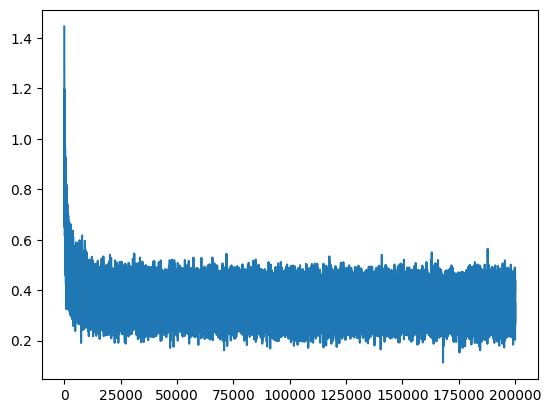

In [14]:
plt.plot(lossi)

## Split Loss 1

In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = { 'train' : [Xtr, Ytr],
             'val' : [Xdev, Ydev],
             'test' : [Xte, Yte]
           }[split]
    # (N, block_size, n_embed)
    emb = C[x]
    # concat into a (N, block_size * n_embed)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # (N, n_hidden)
    h = torch.tanh(hpreact)
    # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [16]:
split_loss('train')

train 2.2306289672851562


In [17]:
split_loss('val')

val 2.2506215572357178


In [18]:
# sample from the model
g = torch.Generator().manual_seed(manualSeed + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        ttc = torch.tensor([context]).to(device)
        emb = C[ttc] # (1, block_size, n_embed)
        embcat = emb.view(1, -1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1).to(device)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g) # this blows up here if we use the gpu ... !
        ix = ix.item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, then break
        if ix == 0:
            break
            
    # decode and print the generated word
    print(''.join(itos[i] for i in out))
        

carlah.
amorilli.
kemri.
rehty.
sacessaeja.
huen.
amerync.
kaqui.
nellara.
chaiir.
kaleig.
dham.
jorn.
quinn.
srockon.
jadii.
wazelo.
dearynixfiaun.
durabee.
deai.


# A) Fixing the initial loss

The first thing we are going to scrutinize is the initialization. The first iteration of the training loop reveals a loss of almost 28, followed by the second iteration going down to 2.8. We should have expected something a lot lower for the first iteration, something closer to the second iteration. 

We should expect something closer to a probability distribution of something even for all 27 characters, meaning the model should predict an equal likelihood for any of the 27 characters. (1/27 = 0.037)

In [19]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [20]:
# a 4-dimensional example of the issue ... so we only have 4 characters.
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
# so if the Y label is 2, then ... 
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [21]:
probs.sum()

tensor(1.)

But what if the 2nd example was very high, like 5 ... then we will have a very low loss, 0.02 ...

In [22]:
# a 4-dimensional example of the issue ... so we only have 4 characters.
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 5., 0.]),
 tensor([0.0066, 0.0066, 0.9802, 0.0066]),
 tensor(0.0200))

But its more likely that some other example will have a high value, and then we wil have a higher loss ...

In [23]:
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 5., 0., 0.]),
 tensor([0.0066, 0.9802, 0.0066, 0.0066]),
 tensor(5.0200))

In [24]:
logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-3.,  5.,  0.,  2.]),
 tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]),
 tensor(5.0553))

What we want is for the logits to be rougly zero when it's initialized, or they just have to be the same value ..

In [25]:
logits = torch.tensor([3.5, 3.5, 3.5, 3.5])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([3.5000, 3.5000, 3.5000, 3.5000]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

So if we take the code from Training Loop 1 and replicate it to Training Loop 2 below, re-run the Model Initialization 1 code, then tweak it to break on the first iteration ...

## Model Initialization 1 (copied from a previous cell)

In [26]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device)
b1 = torch.randn(n_hidden,                        generator=g).to(device)
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device)
b2 = torch.randn(vocab_size,                      generator=g).to(device)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


## Training Loop 2

In [27]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # The only change from Training Loop 1
    break

      0/ 200000: 27.8817
CPU times: user 29 ms, sys: 0 ns, total: 29 ms
Wall time: 8.19 ms


And now we take a look at the logits from the first row of the output layer ...

In [28]:
logits[0]

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

... you can see the logits can take on some extreme values. They vary a lot. 

`This is what is creating the fake confidence and incorrect answers and makes the loss get very high!`

So these logits should all be much closer to zero. 

So how do we do this?

Well if we look at the code in the training loop, we can see the logits are calculated as

logits = h @ W2 + b2


The first thing we can so is modify how we initialize b2. Currently we initialize b2 with randn 

b2 = torch.randn(vocab_size,                      generator=g).to(device)

but we want those numbers to all be zero or close to zero. This can be done by multiplying by 0:

b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0

The second thing we can do is also scale down how we initialize W2. Currently we initialize W2 with randn

W2 = torch.randn((n_hidden, vocab_size), generator=g).to(device)

Let's scale down all those numbers by multiplying by 0.1

W2 = torch.randn((n_hidden, vocab_size), generator=g).to(device) * 0.1

## Model Initialization 2

In [29]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device)
b1 = torch.randn(n_hidden,                        generator=g).to(device)
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device) * 0.1 # change 2
b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0 # change 1

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


## Training Loop 2 (copied from a previous cell)

In [30]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # The only change from Training Loop 1
    break

      0/ 200000: 4.2326
CPU times: user 237 ms, sys: 0 ns, total: 237 ms
Wall time: 39 ms


So now let's run the model initialization 2 code above, re-run the code from training loop 2, then display the logits from row 1.

In [31]:
logits[0]

tensor([-0.2490,  3.5232, -1.2675,  0.5407,  1.6622, -1.1708, -0.1398,  0.1242,
         0.9210,  1.1347,  1.3624, -0.9252,  0.4438, -2.4594, -0.9714,  0.1247,
        -0.9572, -1.3763, -2.3287, -0.1374,  2.4522,  1.6165,  1.6649, -1.0944,
        -2.1544,  0.7255,  1.1413], grad_fn=<SelectBackward0>)

We can now see the training loss on the first iteration is much lower, at 4.2326, and that the logits from the first iteration are all closer to 0.

Ok. That's a good start. But why don't we just multiply W2 by 0.0 to initialize all the weights in W2 to be 0.0?

Let's find out! Replicate the code in Model Initialization 2 into Model Initialization 3, then multiply W2 by zero, display logits[0]

### Model Initialization 3

In [32]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device)
b1 = torch.randn(n_hidden,                        generator=g).to(device)
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device) * 0.0 # only change from Model Initialization 2
b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


Meh ... let's replicate the code from Training Loop 1 into the cell below .. and then run it. We want the entire loop to run ... so no break after the first pass.

## Training Loop 1 (copied from a previous cell)

In [33]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2958
  10000/ 200000: 2.1886
  20000/ 200000: 2.3954
  30000/ 200000: 2.5034
  40000/ 200000: 1.9946
  50000/ 200000: 2.4849
  60000/ 200000: 2.4794
  70000/ 200000: 2.1435
  80000/ 200000: 2.1880
  90000/ 200000: 2.0427
 100000/ 200000: 2.0054
 110000/ 200000: 2.2827
 120000/ 200000: 1.9648
 130000/ 200000: 2.5441
 140000/ 200000: 2.2898
 150000/ 200000: 2.2020
 160000/ 200000: 1.9903
 170000/ 200000: 1.8524
 180000/ 200000: 2.1030
 190000/ 200000: 1.9201
CPU times: user 9min 39s, sys: 820 ms, total: 9min 40s
Wall time: 1min 15s


Now the first iteration produces a loss of 3.3, and if we plot the loss lossi we get:

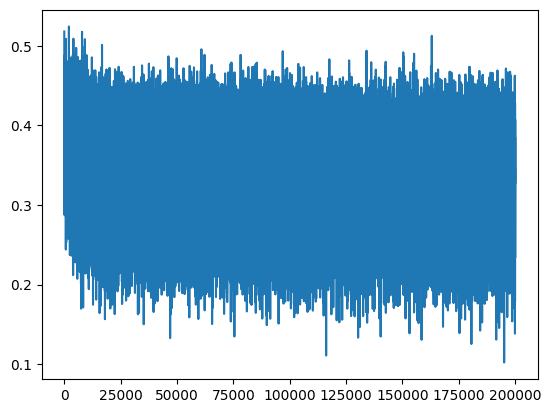

In [34]:
plt.plot(lossi)

Notice we no longer have the 'hockey stick' loss graph, where in the first few iterations of the loss, the optimization is 'squashing down the logits' and then its 'rearranging the logits'. We no longer get the 'easy gains' in the beginning, and the 'hard gains' later. Above we see we are starting with the 'hard gains' right from the beginning, which is what we want.

Now if we display the 'train' and 'val' split loss, we should see an improvement.

## Split Loss 1 (copied from a previous cell)

In [35]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = { 'train' : [Xtr, Ytr],
             'val' : [Xdev, Ydev],
             'test' : [Xte, Yte]
           }[split]
    # (N, block_size, n_embed)
    emb = C[x]
    # concat into a (N, block_size * n_embed)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # (N, n_hidden)
    h = torch.tanh(hpreact)
    # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.1233866214752197
val 2.1638295650482178


This is an improvement from previously where we were getting 2.23 and 2.25. This is because we are spending more iterations on optimizing the neural network instead of spending the first say 1000 iterations squashing down the weights.

# B) Fixing the saturated tanh

The next problem with the code is with the initial values for h:

embcat = emb.view(emb.shape[0], -1)

h = torch.tanh(embcat @ W1 + b1)





Let's plot the values of h into a histogram to see the distribution of values within this tensor:

In [36]:
h.shape

torch.Size([32, 200])

We can view this out and stretch it into one long vector, then call tolist to convert this into one long python list of floats, then pass this into plt.hist and tell it we want 50 bins. The semicolon will suppress printing out a bunch of content we don't want. 

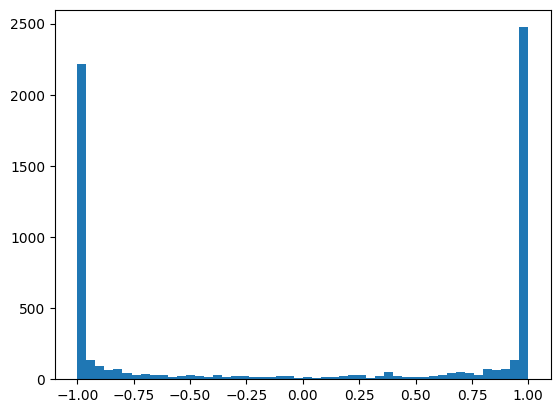

In [37]:
plt.hist(h.view(-1).tolist(), 50);

So you can see from the histogram that most of the values in h take on the value of -1 or 1. 

We can also feed the pre-activations into the histogram in the same manner.

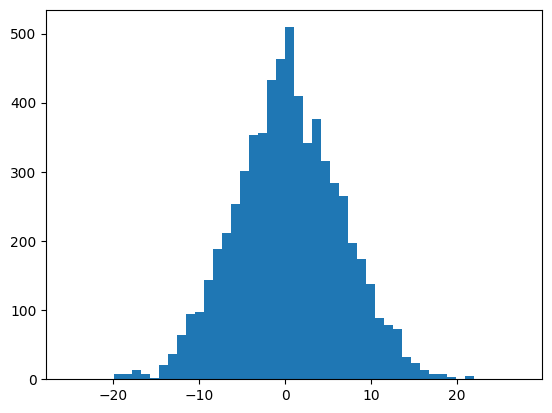

In [38]:
plt.hist(hpreact.view(-1).tolist(), 50);

You can see the pre-activations that we feed into the tanh take on a distribution that is very broad, between -20ish and 20ish. 

![tanh](images/tanh.png)

Recall when we do back propogation through the network, we will back prop through the tanh function, and if the value we feed into tanh is very close to 1 or -1, then looking at the above code, you can see we are 'killing the gradient' and effectively stopping back prop through this tanh unit. 

To get an idea of how much our h values are around -1 or 1, we can plot the values in an image ...

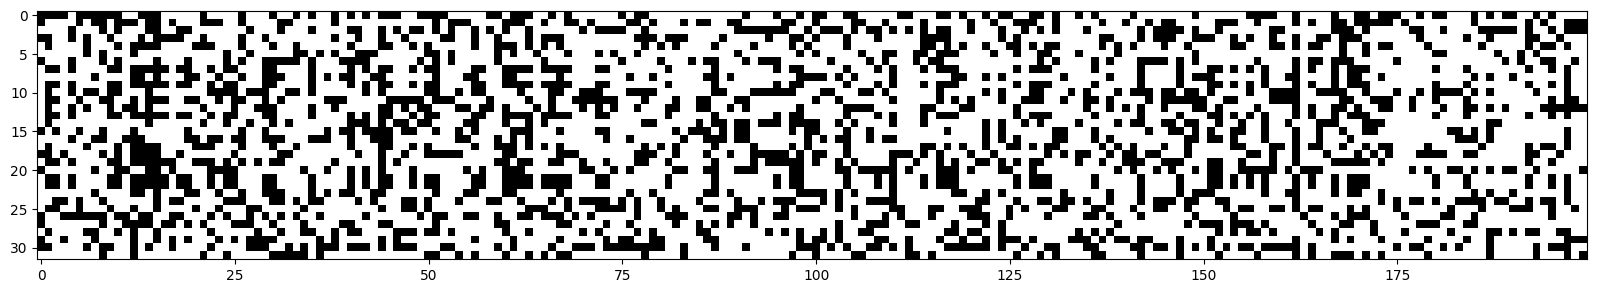

In [39]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In the above image, we see white if h.abs() > 0.99, otherwise we see black. 

If any column was all white, then we would have a dead neuron, and nothing could pass through it. It would never learn.

The solution is for the initial values in hpreact to be closer to zero.

So let's tweak the Model Initialization code to do this:

## Model Initialization 4

In [40]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device) * 0.1  # tweak 3
b1 = torch.randn(n_hidden,                        generator=g).to(device) * 0.01 # tweak 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device) * 0.01 # a slight tweak to not have zero
b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


## Training Loop 2 (copied again from a previous cell)

In [41]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # The only change from Training Loop 1
    break

      0/ 200000: 3.3069
CPU times: user 28.3 ms, sys: 1 µs, total: 28.3 ms
Wall time: 8.19 ms


Re run both histograms:

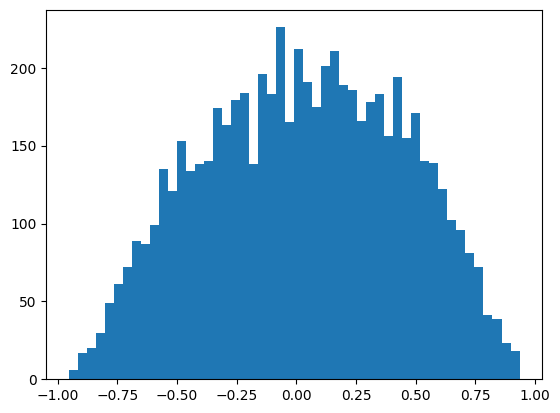

In [42]:
plt.hist(h.view(-1).tolist(), 50);

This is a much better histogram with no saturation on -1 or 1.

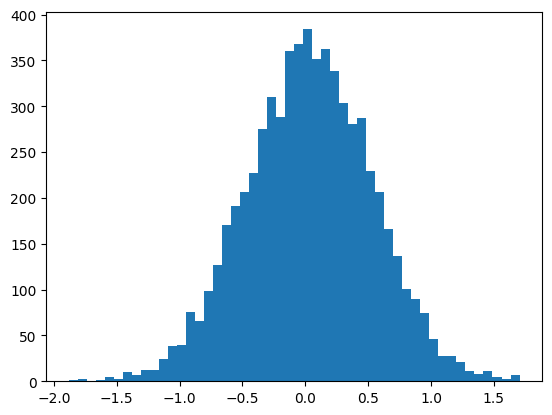

In [43]:
plt.hist(hpreact.view(-1).tolist(), 50);

And the pre-activations are now between -1.5 and 1.5, instead of between -20ish and 20ish.

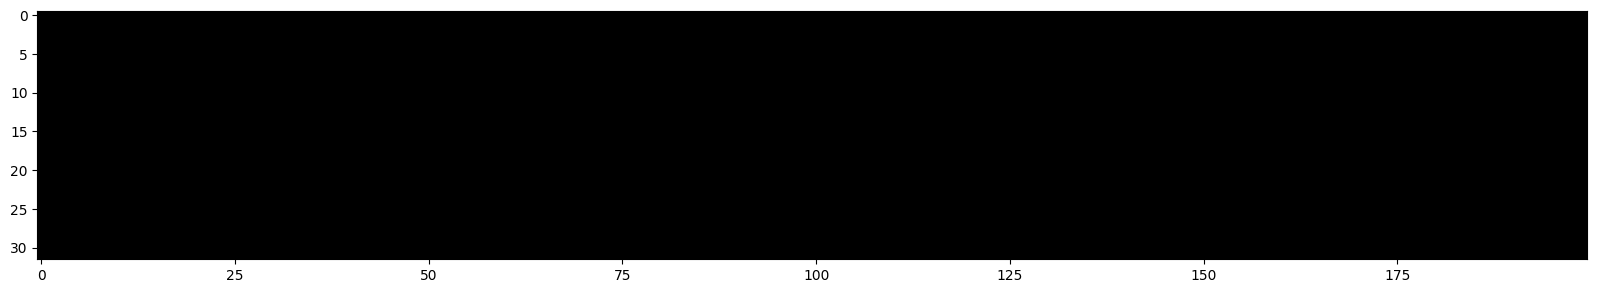

In [44]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

The above we expect a lot less white. There is no white! That's because there are no neurons that saturated above .99 in either direction.

Hmmm ... lets try another small tweak to the Model Initialization code:

## Model Initialization 5

In [45]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device) * 0.2  # the only tweak!
b1 = torch.randn(n_hidden,                        generator=g).to(device) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device) * 0.01 
b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


## Training Loop 2 (copied again from a previous cell)

In [46]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # The only change from Training Loop 1
    break

      0/ 200000: 3.3135
CPU times: user 6.08 ms, sys: 0 ns, total: 6.08 ms
Wall time: 2.11 ms


And now rerun that image ...

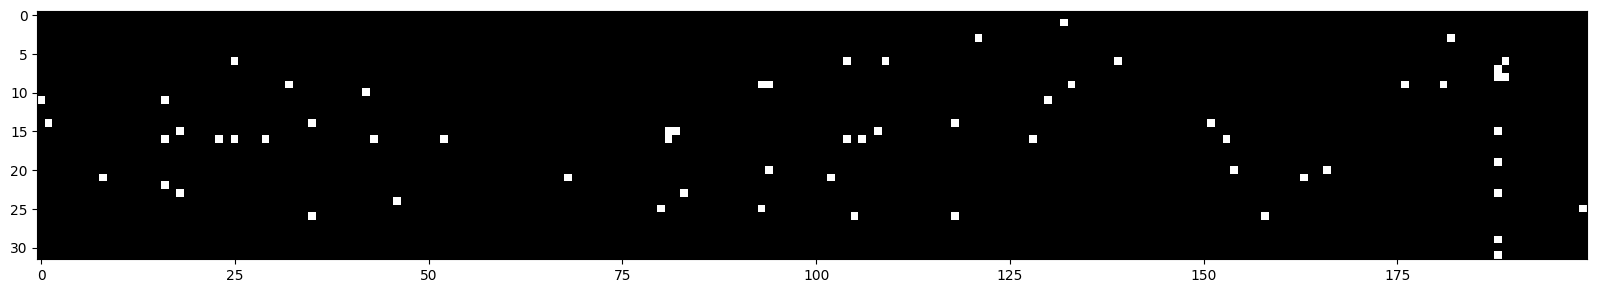

In [47]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

... and both histograms:

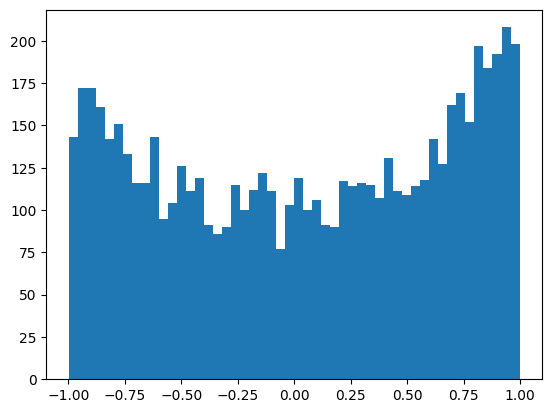

In [48]:
plt.hist(h.view(-1).tolist(), 50);

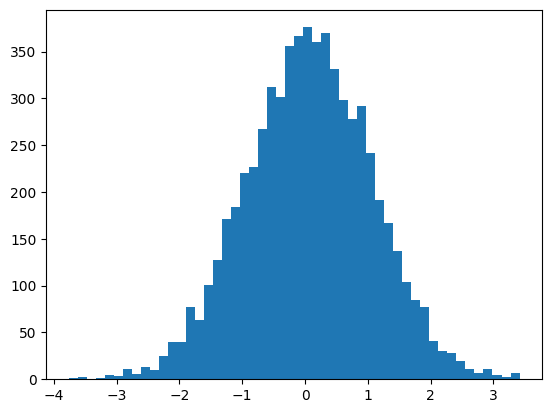

In [49]:
plt.hist(hpreact.view(-1).tolist(), 50);

So knowing what we now know, let's re-run a full training of the data!

## Model Initialization 5 (copied from a previous cell)

In [50]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device) * 0.2  # the only tweak!
b1 = torch.randn(n_hidden,                        generator=g).to(device) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device) * 0.01 
b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


## Training Loop 1 (copied again from a previous cell)

In [51]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.2440
  30000/ 200000: 2.3044
  40000/ 200000: 1.9598
  50000/ 200000: 2.4266
  60000/ 200000: 2.3693
  70000/ 200000: 2.0370
  80000/ 200000: 2.2545
  90000/ 200000: 2.1047
 100000/ 200000: 1.8406
 110000/ 200000: 2.1954
 120000/ 200000: 2.0199
 130000/ 200000: 2.4290
 140000/ 200000: 2.2683
 150000/ 200000: 2.1892
 160000/ 200000: 1.8254
 170000/ 200000: 1.7761
 180000/ 200000: 1.9963
 190000/ 200000: 1.8334
CPU times: user 10min 20s, sys: 1.02 s, total: 10min 21s
Wall time: 1min 21s


## Split Loss 1 (copied from a previous cell)

In [52]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = { 'train' : [Xtr, Ytr],
             'val' : [Xdev, Ydev],
             'test' : [Xte, Yte]
           }[split]
    # (N, block_size, n_embed)
    emb = C[x]
    # concat into a (N, block_size * n_embed)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # (N, n_hidden)
    h = torch.tanh(hpreact)
    # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.081057548522949
val 2.125427722930908


In [53]:
# Here is a summary of how the loss on the training and validation data improved:

# No changes to the Model Initialization
# train 2.2306289672851562
# val 2.2506215572357178

# A) Fix the Initial loss (fix softmas confidently wrong)
# train 2.1233866214752197
# val 2.1638295650482178

# B) Fix the saturated tanh (fix tanh layer saturated at init)
# train 2.081057548522949
# val 2.125427722930908


# C) Calculating the init scale: 'Kaiming init'

No one manually sets these magic numbers when writing their model initialization code. So how do we decide what values to set?

[torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html)

`Returns a tensor filled with random numbers from a normal distribution with mean 0 and variance 1 (also called the standard normal distribution).`

In [54]:
tr = torch.randn(5, 10)
tr

tensor([[-1.1017, -0.9805, -0.7097,  0.3401, -0.9790,  0.0347, -1.0904,  0.1372,
         -0.2162,  0.0629],
        [-0.1716,  2.5590,  2.6611,  0.4733,  0.9708,  0.6371,  0.3973,  0.6790,
          0.2961,  1.1338],
        [-1.8803, -0.1093, -0.3372, -0.1065,  1.1921,  1.3842,  0.4263,  0.3501,
         -2.1491, -0.4780],
        [-0.0504, -0.9599,  3.0437, -0.9889, -1.2253,  1.6682, -0.3919, -1.9672,
          0.4688, -1.0179],
        [-0.4011,  0.3812, -0.6250, -0.0618,  0.5862, -0.5162,  0.0445,  0.6362,
         -0.2539,  0.7597]])

tensor(0.0029) tensor(1.0050)
tensor(0.0093) tensor(3.1548)


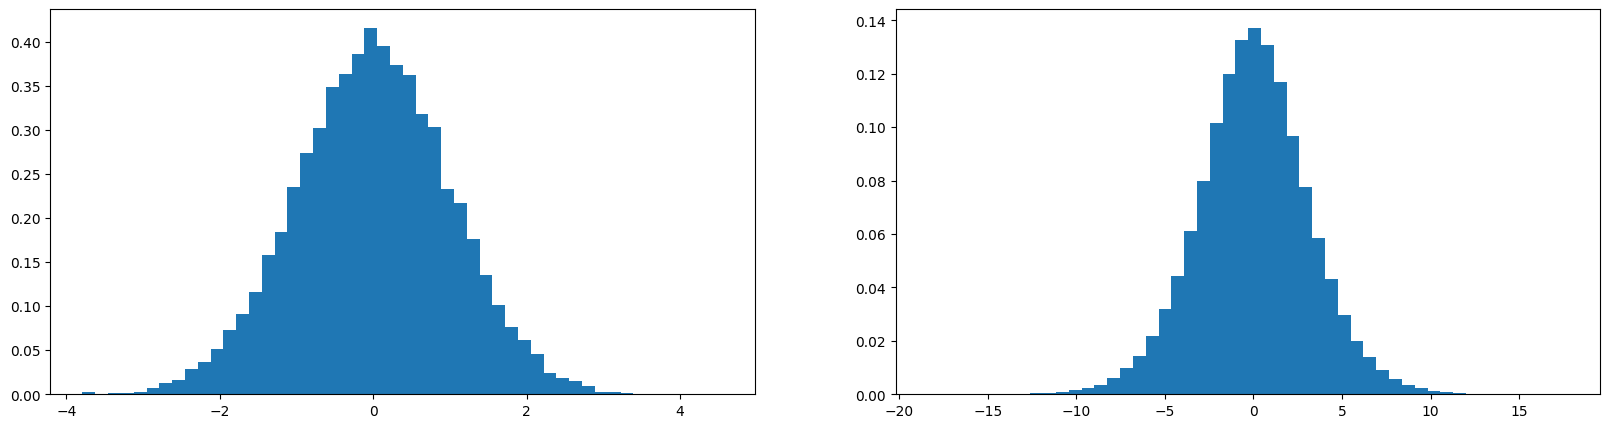

In [55]:
# every time we run this, we will get different numbers.
x = torch.randn(1000, 10) # our input examples
w = torch.randn(10, 200)  # our weights in a hidden layer with 200 neurons
y = x @ w # calculate the pre-activations of these neurons

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

On the left, which shows x, we start with a mean of 0 and a standard deviation of 1 (or very close to those values).

But when we multiply x by w to create y, we see the mean of y is around the same as x (both close to 0), but the standard deviation of y has grown to around 3.

So what we see in the histogram for y on the right is that it is expanding. We DONT WANT THIS! We want our neurons throughout our entire network to have roughly a mean of 0 and a standard deviation of 1.

So how do we do this?

tensor(-0.0166) tensor(1.0132)
tensor(0.0129) tensor(16.6404)


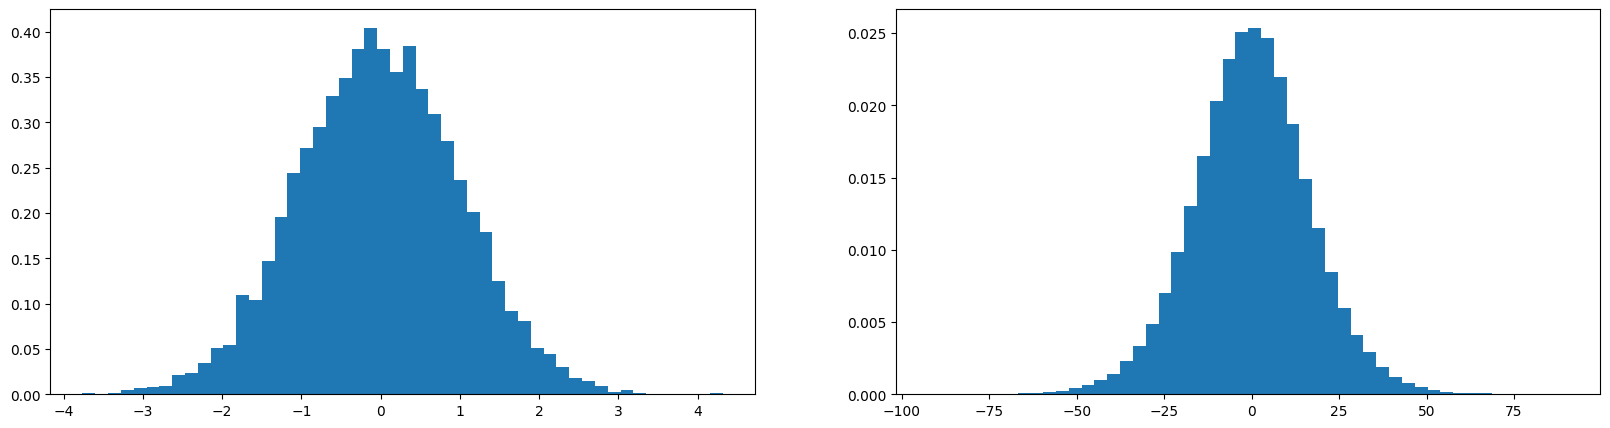

In [56]:
# What happens if we multiply w by a large number?

x = torch.randn(1000, 10) 
w = torch.randn(10, 200) * 5.0 
y = x @ w  
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

The standard deviation of y grows to about 16!

tensor(0.0164) tensor(0.9990)
tensor(-0.0008) tensor(0.6124)


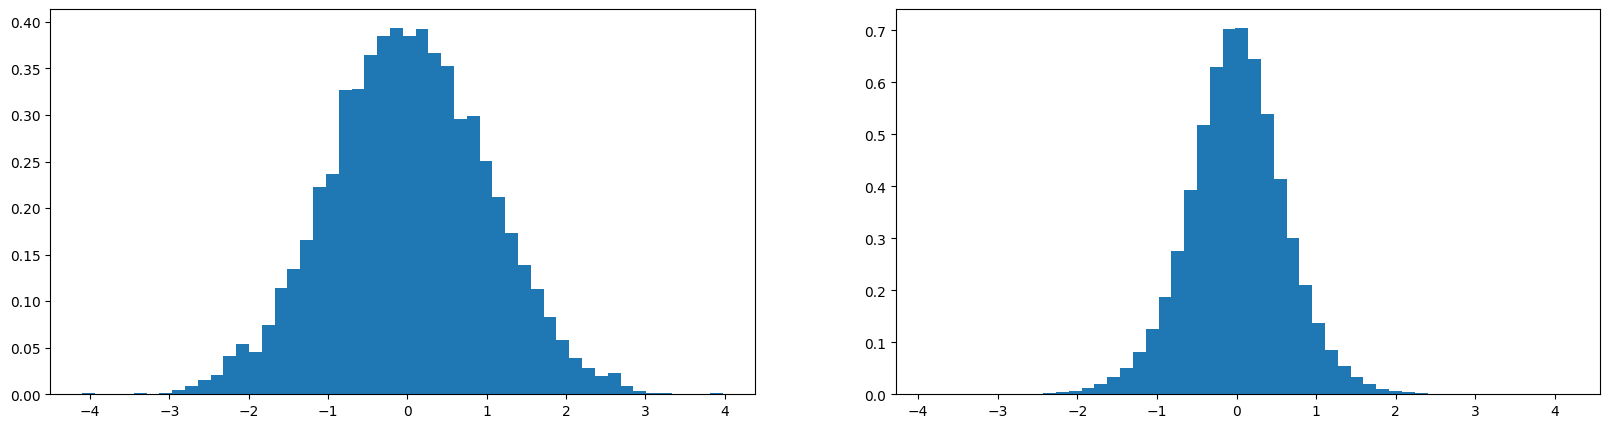

In [57]:
# And what happens if we multiply w by a small number?

x = torch.randn(1000, 10) 
w = torch.randn(10, 200) * 0.2
y = x @ w  
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

The standard deviation of y shrinks to about 0.6!

We want the standard deviation to be around 1, so what scaling factor should we use??

Whelp, turns out we need to DIVIDE by the square root of the 'fan in' ...

tensor(0.0081) tensor(0.9957)
tensor(-0.0008) tensor(0.9915)


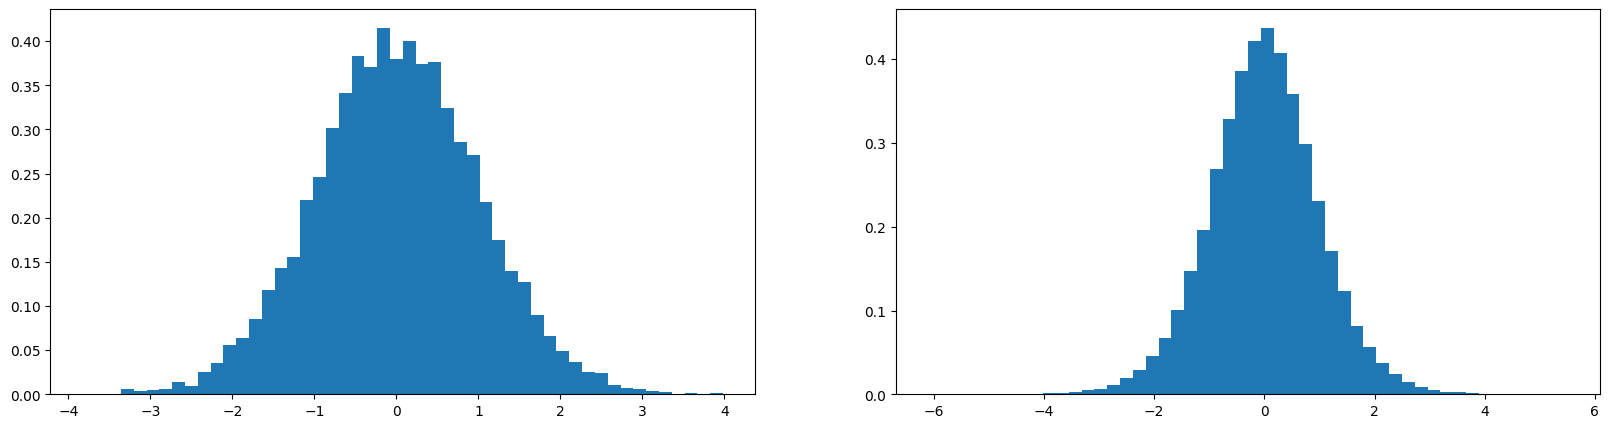

In [58]:
# our fan in for this example is 10, and a way to calculate the 
# square root is to raise the number by 0.5 ... so .. 

x = torch.randn(1000, 10) 
w = torch.randn(10, 200) / (10 ** 0.5)
y = x @ w  
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

Better, right!? Now the standard deviation of y is very close to 1 ... which is what we want!

The details of this square root fan in rule can be found in the [Kaiming init paper](https://arxiv.org/abs/1502.01852)

PyTorch has an implementation of this that can be found at [PyTorch Keiming](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_)

According to Karpathy, this is the most common way today to initialize neural networks.

So to manually apply this keiming initialization to our example, we would do this:

## Model Initialization 6 (Keiming initialization)

In [59]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device) * (5/3) / ((n_embd * block_size)**0.5) # the only tweak!
b1 = torch.randn(n_hidden,                        generator=g).to(device) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device) * 0.01 
b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


## Training Loop 1 (yup! copied again from a previous cell)

In [60]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.2782
  30000/ 200000: 2.3826
  40000/ 200000: 1.9526
  50000/ 200000: 2.3811
  60000/ 200000: 2.3667
  70000/ 200000: 2.0593
  80000/ 200000: 2.2171
  90000/ 200000: 2.1129
 100000/ 200000: 1.8887
 110000/ 200000: 2.2011
 120000/ 200000: 1.9506
 130000/ 200000: 2.3520
 140000/ 200000: 2.2535
 150000/ 200000: 2.2241
 160000/ 200000: 1.8043
 170000/ 200000: 1.7468
 180000/ 200000: 2.0212
 190000/ 200000: 1.8161
CPU times: user 10min 24s, sys: 1.12 s, total: 10min 25s
Wall time: 1min 22s


## Split Loss 1 (copied from a previous cell)

In [61]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = { 'train' : [Xtr, Ytr],
             'val' : [Xdev, Ydev],
             'test' : [Xte, Yte]
           }[split]
    # (N, block_size, n_embed)
    emb = C[x]
    # concat into a (N, block_size * n_embed)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # (N, n_hidden)
    h = torch.tanh(hpreact)
    # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0817906856536865
val 2.1279780864715576


In [62]:
# Here is a summary of how the loss on the training and validation data improved:

# No changes to the Model Initialization
# train 2.2306289672851562
# val 2.2506215572357178

# A) Fix the Initial loss (fix softmas confidently wrong)
# train 2.1233866214752197
# val 2.1638295650482178

# B) Fix the saturated tanh (fix tanh layer saturated at init)
# train 2.081057548522949
# val 2.125427722930908

# C) use semi-principled 'kaiming init' instead of a hacky init 
# train 2.0817906856536865
# val 2.1279780864715576

# D) Batch Normalization

This part goes over the insights from the paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

In [63]:
hpreact.shape

torch.Size([32, 200])

In [64]:
hpreact.mean(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [65]:
hpreact.std(dim=0, keepdim=True).shape

torch.Size([1, 200])

## Model Initialization 7

In [66]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device) * (5/3) / ((n_embd * block_size)**0.5) # the only tweak!
b1 = torch.randn(n_hidden,                        generator=g).to(device) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device) * 0.01 
b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0 

# Batch Normalization START
# batch normalization gain
bngain = torch.ones((1, n_hidden))
# batch normalization bias
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
# Batch Normalization END

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    
# Our parameter count goes up from 11897 to (11897 + 200 + 200) => 12297

12297


## Training Loop 3

In [67]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    
    # Batch Normalization START
    hpreact = bngain * (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) + bnbias
    # Batch Normalization END
    
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.2950
  30000/ 200000: 2.3937
  40000/ 200000: 1.9780
  50000/ 200000: 2.4495
  60000/ 200000: 2.4431
  70000/ 200000: 2.0071
  80000/ 200000: 2.2948
  90000/ 200000: 2.1144
 100000/ 200000: 2.0097
 110000/ 200000: 2.3772
 120000/ 200000: 2.0301
 130000/ 200000: 2.4808
 140000/ 200000: 2.4385
 150000/ 200000: 2.2068
 160000/ 200000: 2.0353
 170000/ 200000: 1.8832
 180000/ 200000: 2.0849
 190000/ 200000: 1.8312
CPU times: user 17min 40s, sys: 1.45 s, total: 17min 41s
Wall time: 2min 18s


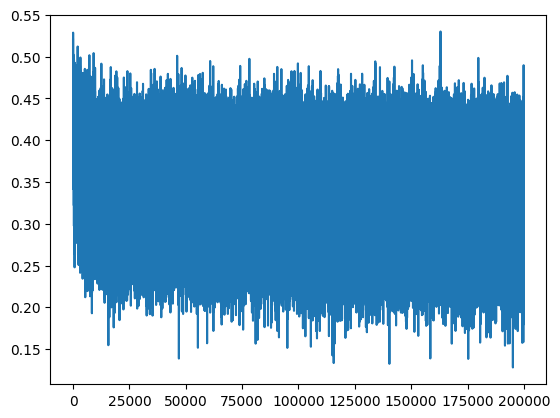

In [68]:
plt.plot(lossi)

## Split Loss 2 (with batch normalization)

In [69]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = { 'train' : [Xtr, Ytr],
             'val' : [Xdev, Ydev],
             'test' : [Xte, Yte]
           }[split]
    # (N, block_size, n_embed)
    emb = C[x]
    # concat into a (N, block_size * n_embed)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
    # Batch normalization
    hpreact = bngain * (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) + bnbias
    
    # (N, n_hidden)
    h = torch.tanh(hpreact)
    # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.111201286315918
val 2.137489080429077


In [70]:
# Here is a summary of how the loss on the training and validation data improved:

# No changes to the Model Initialization
# train 2.2306289672851562
# val 2.2506215572357178

# A) Fix the Initial loss (fix softmas confidently wrong)
# train 2.1233866214752197
# val 2.1638295650482178

# B) Fix the saturated tanh (fix tanh layer saturated at init)
# train 2.081057548522949
# val 2.125427722930908

# C) use semi-principled 'kaiming init' instead of a hacky init 
# train 2.0817906856536865
# val 2.1279780864715576

# D) with Batch Normalization
# train 2.111201286315918
# val 2.137489080429077


This network is small, so we may not see any improvement on the training or validation loss with batch normalization. On larger networks, there will be an improvement. 

It has become the norm that we would add a batch normalization after every linear layer in the network. 

In [71]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass through the training set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd = hpreact.std(dim=0, keepdim=True)

## Split Loss 3

In [72]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = { 'train' : [Xtr, Ytr],
             'val' : [Xdev, Ydev],
             'test' : [Xte, Yte]
           }[split]
    # (N, block_size, n_embed)
    emb = C[x]
    # concat into a (N, block_size * n_embed)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
    # Batch normalization
    # hpreact = bngain * (hpreact - hpreact.mean(dim=0, keepdims=True)) / hpreact.std(dim=0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    
    # (N, n_hidden)
    h = torch.tanh(hpreact)
    # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.111201286315918
val 2.137542724609375


In [73]:
3 * (7 - 5) / 6 + 12

13.0

However, no one wants to calculate this batch mean and std after training, so a better way to do this is to estimate these values DURING training of the network.

## Model Initialization 8

In [74]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device) * (5/3) / ((n_embd * block_size)**0.5) # the only tweak!
b1 = torch.randn(n_hidden,                        generator=g).to(device) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device) * 0.01 
b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0 

# Batch Normalization START
# batch normalization gain
bngain = torch.ones((1, n_hidden))
# batch normalization bias
bnbias = torch.zeros((1, n_hidden))

# Running totals for mean, std START
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))
# Running totals for mean, std END

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
# Batch Normalization END

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    
# Our parameter count goes up from 11897 to (11897 + 200 + 200) => 12297

12297


## Training Loop 4

In [75]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    
    # Batch Normalization START
    # hpreact = bngain * (hpreact - hpreact.mean(dim=0, keepdims=True)) / hpreact.std(dim=0, keepdim=True) + bnbias
    
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    
    # Batch Normalization END
    
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.2950
  30000/ 200000: 2.3937
  40000/ 200000: 1.9780
  50000/ 200000: 2.4495
  60000/ 200000: 2.4431
  70000/ 200000: 2.0071
  80000/ 200000: 2.2948
  90000/ 200000: 2.1144
 100000/ 200000: 2.0097
 110000/ 200000: 2.3772
 120000/ 200000: 2.0301
 130000/ 200000: 2.4808
 140000/ 200000: 2.4385
 150000/ 200000: 2.2068
 160000/ 200000: 2.0353
 170000/ 200000: 1.8832
 180000/ 200000: 2.0849
 190000/ 200000: 1.8312
CPU times: user 19min 15s, sys: 1.47 s, total: 19min 16s
Wall time: 2min 31s


So now we no longer need to do that extra post training step because we have done it during traing. 

## Split Loss 4

In [76]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = { 'train' : [Xtr, Ytr],
             'val' : [Xdev, Ydev],
             'test' : [Xte, Yte]
           }[split]
    # (N, block_size, n_embed)
    emb = C[x]
    # concat into a (N, block_size * n_embed)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
    # Batch normalization
    # hpreact = bngain * (hpreact - hpreact.mean(dim=0, keepdims=True)) / hpreact.std(dim=0, keepdim=True) + bnbias
    # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    
    # (N, n_hidden)
    h = torch.tanh(hpreact)
    # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.1111013889312744
val 2.137741804122925


These values are almost identical to what we got when we did it after training:

train 2.111201286315918

val 2.137542724609375

Turns out we no longer need a weight bias IF we do batch normalization right after a linear layer. When we add a bias to the weights, we subtract that bias in the batch normalization layer, so its useless. 

In our previous example, we can eliminate the code for `b1` because of the batch normalization layer that immediately follows it.

So here is a summarization of everything we have done up to this point. This code is taken from the [karpathy github page](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb) cells 6 and 7

In [77]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


Notice how the model parameter count has gone down by the size of b1 = 200.

In [78]:
%%time 
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6413
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707
CPU times: user 19min 19s, sys: 2.27 s, total: 19min 21s
Wall time: 2min 34s


Karpathy mentions in his video that today there are better ways to do batch normalization than what we have covered above. Remember that batch normalization paper came out in March 2015. 

In [79]:
# resume the video at 1:18:35 ...

## Running the code on the GPU:

This is my side note on getting the above code to run on the GPU, because up to this point, I have not been able to get all of it running error free.

I replicated the Karpathy code from above and tweaked it to use the gpu.

In [80]:
device = torch.device("cuda")  

We have to copy the training, validation and test data sets to the gpu.

In [81]:
Xtrgpu = Xtr.to(device)
Ytrgpu = Ytr.to(device)

Xdevgpu = Xdev.to(device)
Ydevgpu = Ydev.to(device)

Xtegpu = Xte.to(device)
Ytegpu = Yte.to(device)


In [82]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = (torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)).to(device) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = (torch.randn((n_hidden, vocab_size),          generator=g) * 0.01).to(device)
b2 = (torch.randn(vocab_size,                      generator=g) * 0).to(device)

# BatchNorm parameters
bngain = torch.ones((1, n_hidden)).to(device)
bnbias = torch.zeros((1, n_hidden)).to(device)
bnmean_running = torch.zeros((1, n_hidden)).to(device)
bnstd_running = torch.ones((1, n_hidden)).to(device)

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [83]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtrgpu.shape[0], (batch_size,), generator=g).to(device)
    Xb, Yb = Xtrgpu[ix], Ytrgpu[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact).to(device) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0198
 190000/ 200000: 2.1707
CPU times: user 2min 41s, sys: 1.59 s, total: 2min 43s
Wall time: 2min 54s


(Why does this take longer to run on the GPU than the CPU??)

### Split Loss 5 (GPU)

In [84]:
@torch.no_grad() # this decorator disables gradient tracking
def split_lossGPU(split):
    x, y = { 'train' : [Xtrgpu, Ytrgpu],
             'val' : [Xdevgpu, Ydevgpu],
             'test' : [Xtegpu, Ytegpu]
           }[split]
    # (N, block_size, n_embed)
    emb = C[x]
    # concat into a (N, block_size * n_embed)
    embcat = emb.view(emb.shape[0], -1)
    # hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
        
    # Batch normalization
    # hpreact = bngain * (hpreact - hpreact.mean(dim=0, keepdims=True)) / hpreact.std(dim=0, keepdim=True) + bnbias
    # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    
    # (N, n_hidden)
    h = torch.tanh(hpreact)
    # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_lossGPU('train')
split_lossGPU('val')

train 2.0674123764038086
val 2.1056840419769287


## PyTorch-ifying the code

In [85]:
# SUMMARY + PYTORCHIFYING -----
# From cell 13 of ...
# https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb

In [86]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):

        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

In [87]:
2 * 3 + 7

13

In [88]:
# This used to work ... !
# class BatchNorm1d:
    
#     def __init__(self, dim, eps=1e-5, momentum=0.1):
        
#         self.eps = eps
#         self.momentum = momentum
#         self.training = True
#         # parameters trained with backprop
#         self.gamma = torch.ones(dim)
#         self.beta = torch.zeros(dim)
#         # buffers (trained with a running 'momentum update')
#         self.running_mean = torch.zeros(dim)
#         self.running_var = torch.ones(dim)
        
#     def __call__(self, x):
        
#         # calculate the forward pass ... we use the mean and variance of the batch
#         if self.training:
#             xmean = x.mean(dim=0, keepdim=True) # batch mean
#             xvar = x.var(dim=0, keepdim=True) # batch variance
#         else:
#             xmean = self.running_mean
#             xvar = self.running_var
        
#         xhat =(x - mean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
#         self.out = self.gamma * xhat + self.beta
        
#         # update the buffers ... only updated on the forward pass during training.
#         if self.training:
#             with torch.no_grad():
#                 self.running_mean =  (1 - self.momentum) * self.running_mean + self.momentum * xmean
#                 self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
                
#         return self.out
    
#     def parameters(self):
#         return [self.gamma, self.beta] # notice we are not returning the self.running_mean or self.running_var

# from the repo ...
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


In [89]:
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
        

In [90]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

In [91]:
g = torch.Generator().manual_seed(manualSeed)

In [92]:
C = torch.randn((vocab_size, n_embd), generator=g)

In [93]:
# The github repo shows this ...
# layers = [
#     Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    
#     Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    
#     Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
# ]

# But the video shows this ...
layers = [
    Linear(n_embd * block_size, n_hidden),  Tanh(),
    
    Linear(n_hidden, n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden),  Tanh(),
    
    Linear(n_hidden, vocab_size), 
]

In [94]:
# The github repo shows this ... and further into the video, 
# he adds this additional code to the layers to demonstrate
# how adding these BatchNord1d layers in between every 
# linear layer and tanh layer
# that we get a more stable network and better results.
# SO I WILL OVERRIDE THE ABOVE AND USE THIS ... 
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

In [95]:
temp = torch.arange(10)
temp

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [96]:
print(temp[-2])
print(temp[:-1])

tensor(8)
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


In [97]:
# This code used to work when the Layers did NOT have BatchNordId ...
# adding in that code broke this ..
# with torch.no_grad():
#     # last layer: make less confident
#     layers[-1].weight *= 0.1
#     # all other layers: apply gain
#     for layer in layers[:-1]:
#         if isinstance(layer, Linear):
#             layer.weight *= 5/3

# so now it must be tweaked to become this ...
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3


In [98]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

47024


In [99]:
for p in parameters:
    p.requires_grad = True

In [100]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
        
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break # AFTER DEBUG: would take out to obviously run full optimization
        

      0/ 200000: 3.2790
CPU times: user 24.1 s, sys: 15.8 ms, total: 24.1 s
Wall time: 3.15 s


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.69%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.81%
layer 8 (      Tanh): mean +0.01, std 0.64, saturated: 2.75%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.03%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.00%


Text(0.5, 1.0, 'activation distribution')

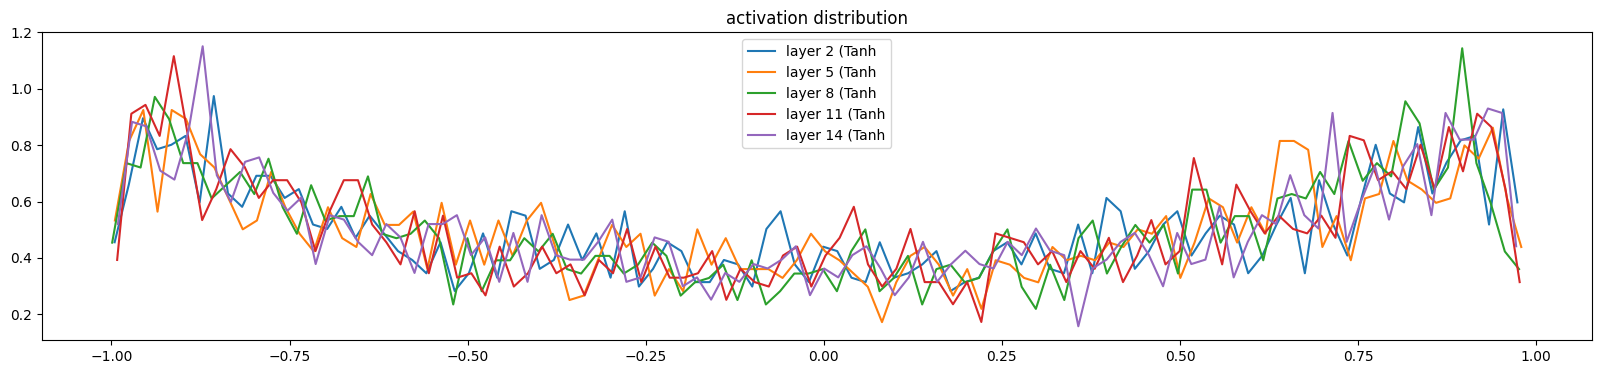

In [101]:
# visualize histograms FORWARD PASS
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.326365e-03
layer 5 (      Tanh): mean +0.000000, std 2.753098e-03
layer 8 (      Tanh): mean -0.000000, std 2.410433e-03
layer 11 (      Tanh): mean +0.000000, std 2.087298e-03
layer 14 (      Tanh): mean +0.000000, std 2.003199e-03


Text(0.5, 1.0, 'gradient distribution')

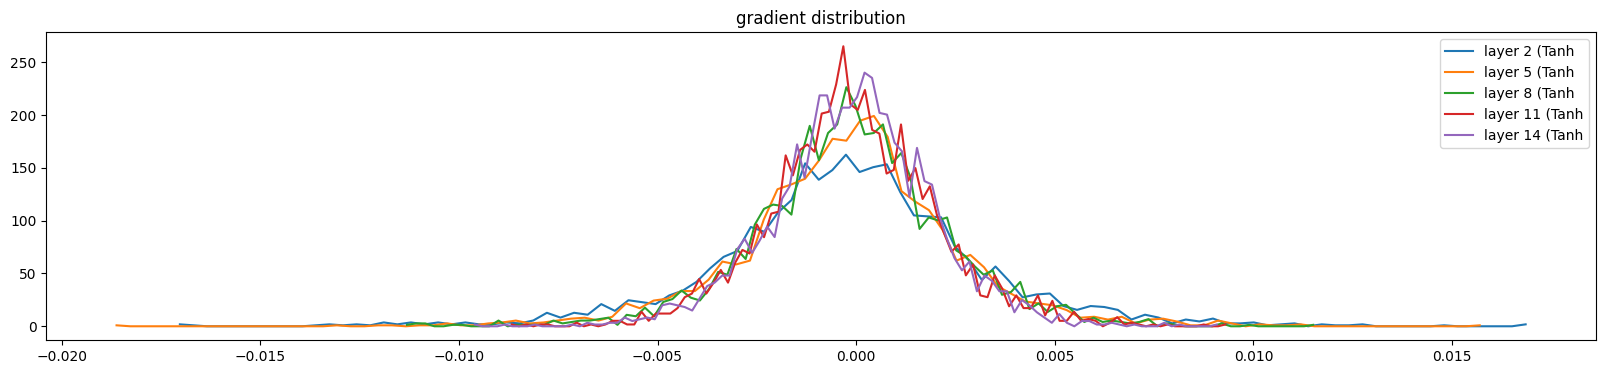

In [102]:
# visualize histograms BACKWARD PASS
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.123361e-02 | grad:data ratio 1.122232e-02
weight  (30, 100) | mean +0.000146 | std 1.331374e-02 | grad:data ratio 7.056627e-02
weight (100, 100) | mean +0.000090 | std 9.929926e-03 | grad:data ratio 9.747058e-02
weight (100, 100) | mean +0.000076 | std 8.491847e-03 | grad:data ratio 8.274510e-02
weight (100, 100) | mean -0.000029 | std 7.753666e-03 | grad:data ratio 7.685590e-02
weight (100, 100) | mean -0.000014 | std 7.297317e-03 | grad:data ratio 7.176655e-02
weight  (100, 27) | mean +0.000183 | std 1.445728e-02 | grad:data ratio 1.356719e-01


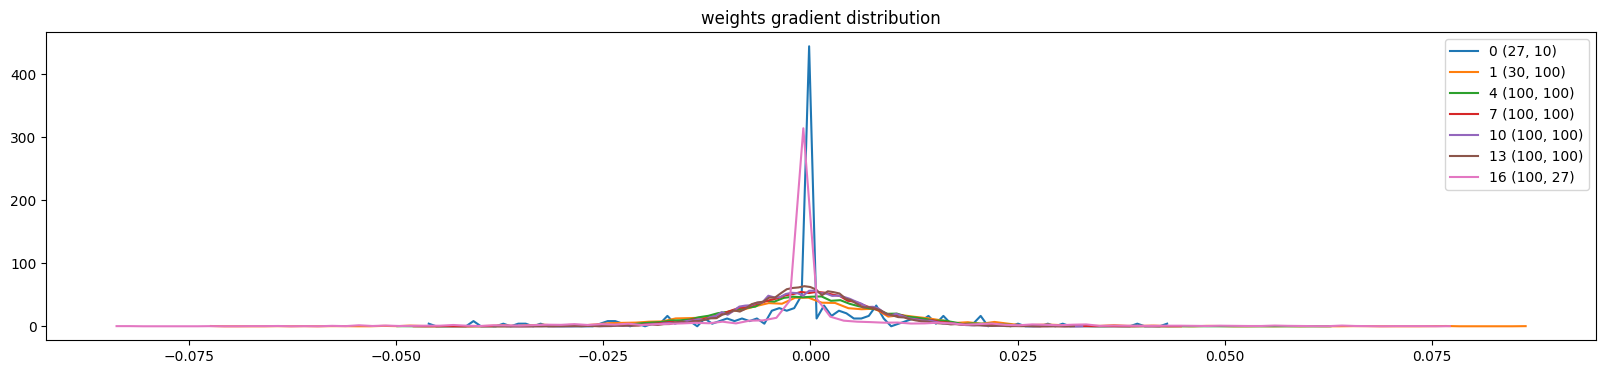

In [103]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

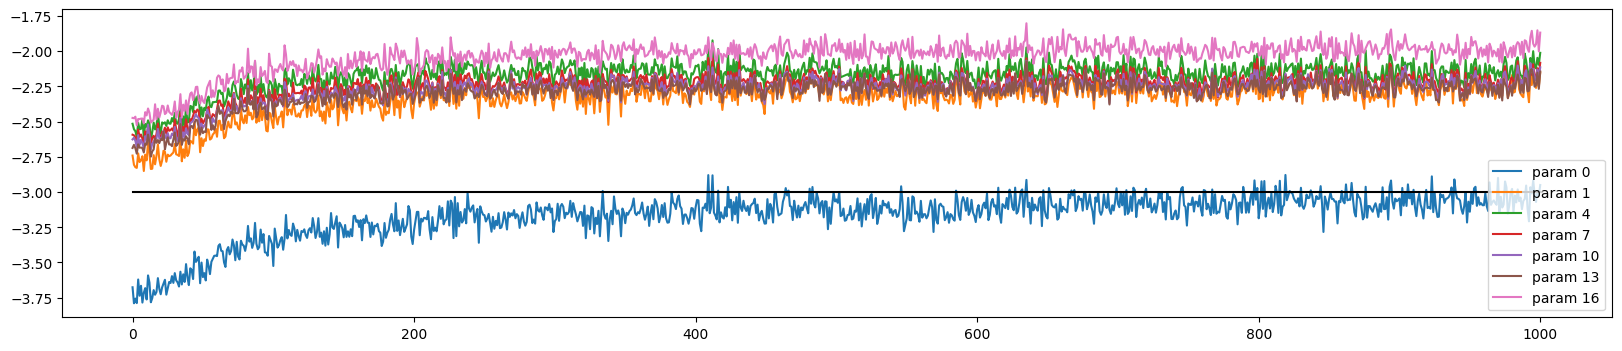

In [104]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [105]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 2.39247465133667
val 2.3912580013275146


In [106]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

chamahxqailhl.
khkimrixreety.
sacaysaejanhnen.
deliahti.
gqei.
nerania.
chaiiv.
kalein.
dham.
join.
qhijth.
roilea.
jadbi.
wazerogijaryxi.
janeelinsaile.
dediia.
gtleley.
rey.
apaimina.
husya.


In [107]:
# DONE; BONUS content below, not covered in video

In [108]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
    g = torch.Generator().manual_seed(2147483647+1)
    x = torch.randn(5, generator=g) * 5
    x[0] = x0 # override the 0th example with the slider
    mu = x.mean()
    sig = x.std()
    y = (x - mu)/sig

    plt.figure(figsize=(10, 5))
    # plot 0
    plt.plot([-6,6], [0,0], 'k')
    # plot the mean and std
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
    # plot little lines connecting input and output
    for i in range(len(x)):
        plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
    # plot the input and output values
    plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
    plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
    plt.xlim(-6, 6)
    # title
    plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [109]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [110]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559


In [111]:
endTime = time.time()

elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")

# Run Date: Monday, June 12, 2023
# Run Time: 00:15:54
